In [362]:
using JuMP, GLPK
using VoronoiCells, GeometryBasics, Plots
using Random
using Statistics
using Distributions
using StatsBase
using Combinatorics

In [372]:
import Pkg; Pkg.add("Iterators")

LoadError: The following package names could not be resolved:
 * Iterators (not found in project, manifest or registry)


In [382]:
x = [1:3]
collect(combinations(1:3,2))

3-element Vector{Vector{Int64}}:
 [1, 2]
 [1, 3]
 [2, 3]

In [492]:
function get_cost_matrix(x, y, norm=2)    
    m = size(x)[1]
    n = size(y)[1]
    #Calculo los costos Cij = |xi-yj| (distancia euclidea en R^2)
    c1 = (x[:,1]*ones(1,n) - ones(m,1)*y[:,1]').^norm
    c2 = (x[:,2]*ones(1,n) - ones(m,1)*y[:,2]').^norm
    return (c1+c2).^(1/norm)
end

function plot_locations(x, title)
    
    gr()
    Plots.GRBackend()
    
    m = size(x)[1]
    
    X = x[:,1]
    Y = x[:,2]
    
    scatter(X, Y, aspect_ratio=:equal, markersize = 3, xlim = (-0.1, 1.1), ylim = (-0.1, 1.1), title = title, legend = false)
    
end

function plot_stations(y, title)
   
    plot_locations(y, title)
    
    n = size(y)[1];
    
    points = [Point2(y[i,1], y[i,2]) for i in 1:n];
    
    scatter!(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
    
end

function plot_assignments(x, y, Pi, voronoi = true)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]

    # Create Stations List
    points = [Point2(y[i,1], y[i,2]) for i in 1:n] 

    # Voronoi Cells
    rect = Rectangle(Point2(0, 0), Point2(1, 1))
    tess = voronoicells(points, rect);
        
    if voronoi == true
        plot(tess, color = :green, alpha = 0.4)
    end

    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    for i = 1:n
        scatter!(X[i], Y[i], aspect_ratio=:equal, markersize = 3, legend =false) # Plot EVs (differente color by each Station)
    end
        
    scatter!(y[:,1], y[:,2], markersize = 8, label = "Stations", markershape = :star, color=:white) # Plot Stations
    annotate!([(points[i][1] + 0.04, points[i][2] + 0.00, text(i, :black)) for i in 1:n]) # Add Station Number
end




function Print_Model(C, s_max)
    
    m = size(C)[1];
    n = size(C)[2];
   
    model = JuMP.Model(GLPK.Optimizer)
        
    @variable(model,Pi[1:m,1:n]>=0)
    
    p = sum(Pi, dims=2);
    s = sum(Pi, dims=1);

    @constraint(model, p .== q)
    @constraint(model, con, s .<= s_max) 

    @objective(model, Min, sum( C.*Pi ))

    optimize!(model)   

    Pi = value.(Pi)
    
    mu = dual.(con)
    print(mu)
    
#     plot_assignments(x, y, Pi)
    
    return mu, Pi;
    
#     y_1 = y[1:2,:]
#     mu_1 = mu[1:2,:]
#      plot_locations_with_condition(y_1, mu_1)
#     plot_locations_with_condition(y[2:3,:], mu[2:3,:])

    
end

function myfindall(condition, x)
    results = Int[]

    for i in 1:length(x)
       if condition(x[i])
           push!(results, i)
       end
    end
    
    return results
    
end

function plot_locations_with_condition(y, mu)
    
    x = rand(100000, 2);
        
    # Equation:
    # ||y1 - x|| - ||y2 - x|| == mu1 - mu2
    
    # ||y1 - x||
    d1 = broadcast(-, x, y[1,:]').^2;
    d1 = sum(d1, dims=2);
    d1 = sqrt.(d1)
    
    # ||y2 - x||
    d2 = broadcast(-, x, y[2,:]').^2;
    d2 = sum(d2, dims=2);
    d2 = sqrt.(d2)
    
    # ||y1 - x|| - ||y2 - x||
    difference_of_distances = d1 - d2;
    
    #  mu1 - mu2
    mu_condition = mu[1] - mu[2];
    
    # As true equality doesnt exist in numerical problems. A tolerance must be set.
    tolerance = 10^(-3);
    
    # ||y1 - x|| - ||y2 - x|| == mu1 - mu2
    condition_index = myfindall(d -> abs(d - mu_condition) <= tolerance, difference_of_distances)
    
    valid_x = x[condition_index, :]
    
    m = size(valid_x)[1]
    
    X = valid_x[:,1]
    Y = valid_x[:,2]
    
#     display(scatter!(X, Y, aspect_ratio=:equal, markersize = 2, legend = false,color=:black, markerstrokewidth=0))
    scatter!(X, Y, aspect_ratio=:equal, markersize = 2, legend = false,color=:black, markerstrokewidth=0)

end

function plot_all_hyperbolic_combinations(x,y,Pi)
    
    n = size(y)[1]
    comb = collect(combinations(1:n,2))

    plot_assignments(x, y, Pi)

    for c in comb   

        first_index = c[1]
        second_index = c[2]

        y_1 = y[first_index,:]
        mu_1 = mu[first_index]

        y_2 = y[second_index,:]
        mu_2 = mu[second_index]

        y_n = [y_1 y_2]'
        mu_n = [mu_1 mu_2]

        plot_locations_with_condition(y_n, mu_n)

    end

    display(plot!())
end

plot_all_hyperbolic_combinations (generic function with 1 method)

## Stations

In [485]:
Random.seed!(2)
y = rand(3,2)
y
# plot_stations(y, "Stations")

3×2 Matrix{Float64}:
 0.366796  0.819338
 0.523879  0.501371
 0.210256  0.559355

## Cars

In [497]:
number_points = 500
x = rand(number_points, 2);
norm = 2;
C = get_cost_matrix(x, y, norm);
q = ones(number_points,1);
s_max = [100 400 50];

[-0.09743322114897054 0.0 -0.168695186610746]

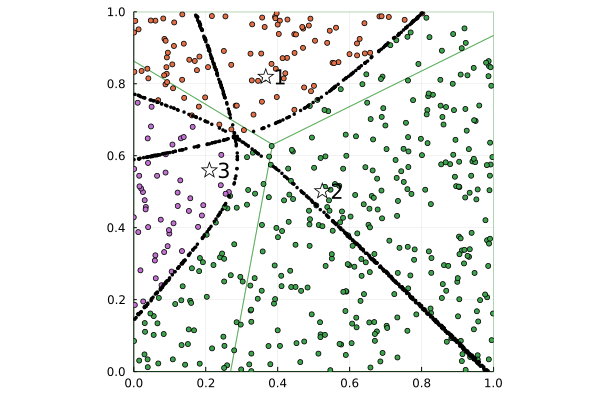

In [498]:
mu, Pi = Print_Model(C, s_max);
plot_all_hyperbolic_combinations(x,y,Pi)